In [50]:
from pathlib import Path
import sys
import numpy as np
from collections import defaultdict
import torch
from torch.utils.tensorboard.writer import SummaryWriter
from rl_envs.grid_world_env import GridWorldEnv
import numpy as np
from tools.helper import *
# from rl_envs.episodic_grid_world_env import EpisodicGridWorldEnv
# from rl_envs.grid_world_env import GridWorldEnv
from ReplayMemory import *
# from agents.DQN import DeepQLearningAgent
from agents.DQN_exact_book import DeepQLearningAgent
%load_ext autoreload 
# %aimport rl_envs.grid_world_env

%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:

def print_actions(agent, env, get_optimal = False):
    with torch.no_grad():
        # action_mapping = [" ↓ "," ↑ "," → "," ← "," ↺ "]
        for i in range(env.height):
            print("[", end=" ")
            for j in range(env.width):
                state = agent.state_normalize((i,j), env.height, env.width)
                # state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
                action = agent.get_action(state)
                print(env.action_mappings[action], end=" ")
            print("]")

# def state_normalize(state, height, width):
#     # normalize each to [0,1]
#     return (state[0]/(height-1),state[1]/(width-1))




BATCHSIZE = 100
LEARN_RATE = 1e-4 # change to 1e-4
TRUE_RANDOM_STATE_VALUE = [
    [-3.8, -3.8, -3.6, -3.1, -3.2],
    [-3.8, -3.8, -3.8, -3.1, -2.9],
    [-3.6, -3.9, -3.4, -3.2, -2.9],
    [-3.9, -3.6, -3.4, -2.9, -3.2],
    [-4.5, -4.2, -3.4, -3.4, -3.5],         
]
discounted_factor = 0.9

# TODO
# def calculate_state_value_error(env:GridWorldEnv,agent):
#     # offline policy have 2 policies, I am using the behavior(random) policy for calculating
#     with torch.no_grad():
#         state_value_error = 0
#         Q = {}
#         for i in range(env.height):
#             for j in range(env.width):
#                 for action_ind in range(env.possible_actions):
#                     state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
#                     action = torch.tensor(action_ind/(env.possible_actions-1), dtype=torch.float).unsqueeze(0)
#                     sa_pair = torch.cat([state,action], dim=1)
#                     Q[(i,j)] = agent.policy_net(sa_pair)
#                     state_value = output.sum()/env.possible_actions
#                     state_value_error += (state_value - TRUE_RANDOM_STATE_VALUE[i][j])
#     return state_value_error




In [52]:

env = GridWorldEnv(5, 5, forbidden_grids=[(1,1),(1,2), (2,2),(3,1),(3,3),(4,1)], target_grids=[(3,2)], forbidden_reward=-1, hit_wall_reward=-1, target_reward=10)
agent = DeepQLearningAgent(input_dim=3, output_dim=1, action_space=env.possible_actions, lr = LEARN_RATE, discounted_factor=discounted_factor)
writer = SummaryWriter()


In [53]:
"""
generate samples to replay buffer
"""


replay_buffer = ReplayMemory(10000)

state = env.reset()
for _ in range(10000):
    action = random.randint(0,4)
    next_state, reward = env.step(state, action)
    action = float(action)  / env.possible_actions # action also normalzie into [0,1]
    replay_buffer.push(torch.tensor(agent.state_normalize(state, env.height, env.width), dtype=torch.float), torch.tensor(action, dtype=torch.float).unsqueeze(0), torch.tensor(reward, dtype=torch.float).unsqueeze(0), torch.tensor(agent.state_normalize(state, env.height, env.width), dtype=torch.float))
    state = next_state



In [54]:
"""
perform DQN
"""
iter_counter = 0
C = 50
for _ in range(10000):
    # for _ in range(50):
    transitions  = replay_buffer.sample(BATCHSIZE)
    batch = Transition(*zip(*transitions))
    state = torch.stack(batch.state)
    next_state = torch.stack(batch.next_state)
    reward = torch.cat(batch.reward)
    action_indices = torch.cat(batch.action)

    loss, q_value, target_value = agent.update_Q_network(state, action_indices, reward, next_state)
    # copy target network every C=5 iteration
    # state_value_estimated = output.sum(dim=1) / env.possible_actions 
    writer.add_scalar('TD error', (q_value - target_value).sum(), iter_counter)         
    writer.add_scalar('Loss', loss.sum(), iter_counter)
    # writer.add_scalar('State value error', calculate_state_value_error(env,agent), iter_counter)
    iter_counter+=1
    if iter_counter % C == 0:
    # agent.target_net.load_state_dict(agent.policy_net.state_dict())
        agent.sync_target_network()
    # print(loss)

In [55]:
print(env)

print_actions(agent, env, True)

print()

# for i in range(env.height):
#     print("[", end=" ")
#     for j in range(env.width):
#         state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
#         output = agent.policy_net(state)
#         state_value = output.sum()/env.possible_actions
#         state_value_error = (state_value - TRUE_RANDOM_STATE_VALUE[i][j])
#         print(state_value_error, end=" ")
#     print("]")


[ 0.000000 0.000000 0.000000 0.000000 0.000000 ]
[ 0.000000 -1.000000 -1.000000 0.000000 0.000000 ]
[ 0.000000 0.000000 -1.000000 0.000000 0.000000 ]
[ 0.000000 -1.000000 10.000000 -1.000000 0.000000 ]
[ 0.000000 -1.000000 0.000000 0.000000 0.000000 ]

[  ↺   ↺   ↺   ↺   ↺  ]
[  ↺   ↓   ↓   ↓   ↺  ]
[  ↺   ↓   ↓   ↓   →  ]
[  ↓   →   ↓   ↓   ↓  ]
[  ↓   →   →   ←   ↓  ]



In [56]:
Q = {}
for i in range(env.height):
    for j in range(env.width):
    #    state = (y,x)
        state = torch.tensor((i,j), dtype=torch.float).unsqueeze(0)
        q_values = agent.policy_net(state)
        Q[(i,j)] = q_values
print_by_dict(env,Q)
                                                                                                                                                                                                                     
                                 

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x2 and 3x100)

In [ ]:
V = {}
for state in Q.keys():
    V[state] = torch.max(Q[state]).item()
print_by_dict(env, V)


[ 0.12 0.20 0.28 0.36 0.44 ]
[ 0.22 0.27 0.33 0.43 0.52 ]
[ 0.32 0.37 0.43 0.51 0.60 ]
[ 0.43 0.47 0.52 0.59 0.68 ]
[ 0.55 0.57 0.61 0.69 0.76 ]


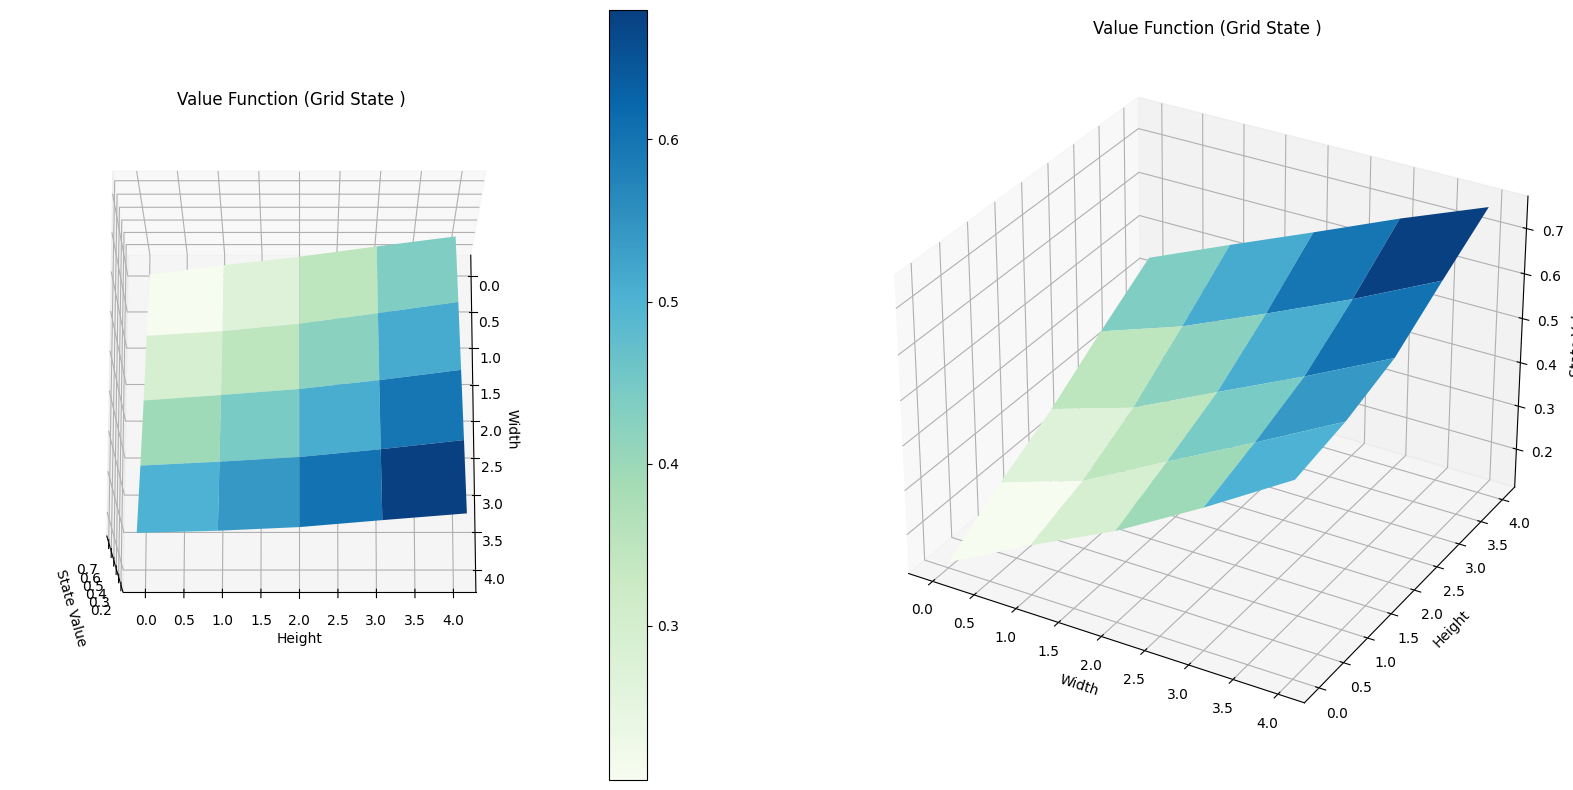

In [ ]:
plot_value_function(V)